# Understanding cloud organization with MaskRCNN using Keras/Tensorflow

This kernel is a first attempt to use a MaskRCNN to solve the cloud organization classification problem. It also helps to evaluate how promising the results are within the allowed processing time on kernels as it is likely such model will take much longer to train properly. It is using the [Matterplot implementation of MaskRCNN](https://github.com/matterport/Mask_RCNN) and is inspired from [this kernel](https://www.kaggle.com/pednoi/training-mask-r-cnn-to-be-a-fashionista-lb-0-07) from the iMaterialist competition. If you are particularly interested in data cleaning for a MaskRCNN, I have also created [another kernel](https://www.kaggle.com/frlemarchand/keras-maskrcnn-kuzushiji-recognition) for the Kuzushiji recognition competition which may be of help.

### If you find this kernel useful, please give an upvote! :)

In [4]:
import os
import gc
import sys
import time
import json
import glob
import random
from pathlib import Path
import pandas as pd

In [5]:
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

import itertools
from tqdm import tqdm

In [6]:
train_df = pd.read_csv("../input/understanding_cloud_organization/train.csv")
train_df = train_df.dropna()

In [7]:
train_df.head()

Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...
5  002be4f.jpg_Flower  1339279 519 1340679 519 1342079 519 1343479 51...
7   002be4f.jpg_Sugar  67495 350 68895 350 70295 350 71695 350 73095 ...

The following cells are simply to arrange the data in such format so that it can be fed to the MaskRCNN. For each image, we can a list of masks in RLE (the "EncodedPixels" column) and the corresponding cloud category ("CategoryId")

In [8]:
category_list = ["Fish","Flower","Gravel","Sugar"]

In [9]:
training_dict = {}
training_class_dict = {}
for col, row in train_df.iterrows():
    image_filename = row.Image_Label.split("_")[0]
    class_name = row.Image_Label.split("_")[1]
    class_id = category_list.index(class_name)
    if training_dict.get(image_filename):
        training_dict[image_filename].append(row.EncodedPixels)
        training_class_dict[image_filename].append(class_id)
    else:
        training_dict[image_filename] = [row.EncodedPixels]
        training_class_dict[image_filename] = [class_id]

In [10]:
data = pd.DataFrame(columns=["image_id","EncodedPixels","CategoryId","Width","Height"])
for key, value in training_dict.items():
    image = Image.open("../input/understanding_cloud_organization/train_images/{}".format(key))
    width, height = image.width, image.height
    data = data.append({"image_id": key, "EncodedPixels": value, "CategoryId": training_class_dict[key],
                        "Width": width, "Height": height},ignore_index=True)


In [11]:
data.head()

image_id                                      EncodedPixels CategoryId  \
0  0011165.jpg  [264918 937 266318 937 267718 937 269118 937 2...     [0, 1]   
1  002be4f.jpg  [233813 878 235213 878 236613 878 238010 881 2...  [0, 1, 3]   
2  0031ae9.jpg  [3510 690 4910 690 6310 690 7710 690 9110 690 ...  [0, 1, 3]   
3  0035239.jpg  [100812 462 102212 462 103612 462 105012 462 1...     [1, 2]   
4  003994e.jpg  [2367966 18 2367985 2 2367993 8 2368002 62 236...  [0, 2, 3]   

  Width Height  
0  2100   1400  
1  2100   1400  
2  2100   1400  
3  2100   1400  
4  2100   1400

# Setting the MaskRCNN

In [12]:
DATA_DIR = Path('../kaggle/input/')
ROOT_DIR = "../../working"

NUM_CATS = len(category_list)
IMAGE_SIZE = 512

In [13]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 27.49 MiB/s, done.
Resolving deltas: 100% (565/565), done.


In [14]:
sys.path.append(ROOT_DIR+'/Mask_RCNN')
from mrcnn.config import Config

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

We will use the COCO weights for the MaskRCNN as a base, even though the images are from a different domain than our satellite images.

In [15]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

-rw-r--r-- 1 root root 246M Aug 16 17:40 mask_rcnn_coco.h5


In [16]:
class CloudConfig(Config):
    NAME = "cloud"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 #That is the maximum with the memory available on kernels
    
    BACKBONE = 'resnet101'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 4500
    VALIDATION_STEPS = 500
    
config = CloudConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [17]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [18]:
class Clouddataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(category_list):
            self.add_class("cloud", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("cloud", 
                           image_id=row.name, 
                           path='../../input/understanding_cloud_organization/train_images/'+str(row.image_id), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])
            
    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [category_list[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    

We define that 90% of the data will be used for training and 10% left for validation, before displaying some examples of masks.

('../../input/understanding_cloud_organization/train_images/a9c7fd3.jpg', ['Fish', 'Gravel'])


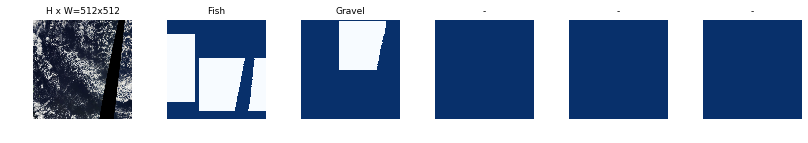

('../../input/understanding_cloud_organization/train_images/02c3e33.jpg', ['Fish', 'Sugar'])


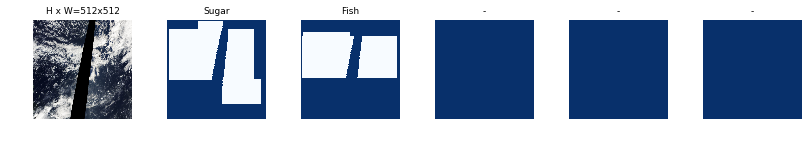

('../../input/understanding_cloud_organization/train_images/29f7bea.jpg', ['Flower'])


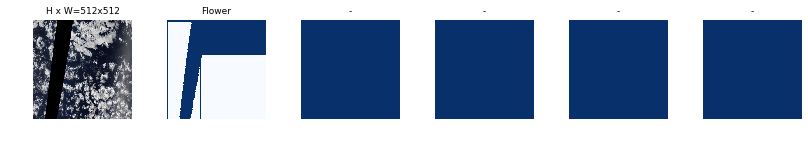

('../../input/understanding_cloud_organization/train_images/476f864.jpg', ['Fish', 'Gravel', 'Sugar'])


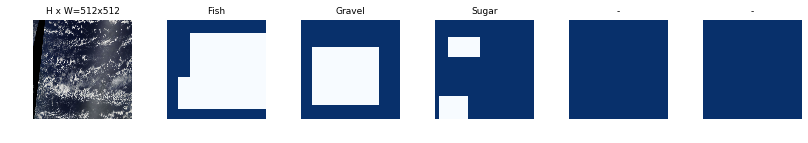

('../../input/understanding_cloud_organization/train_images/db4030a.jpg', ['Fish', 'Sugar'])


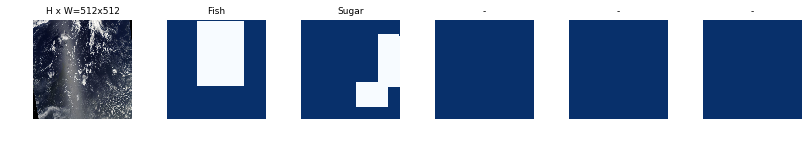

In [19]:
# Training dataset 
train_frac = 0.9

train_size = int(train_frac*len(data))
valid_size = int((1-train_frac)*len(data))

train_data = Clouddataset(data[:train_size])
train_data.prepare()
# # Validation Dataset
valid_data = Clouddataset(data[train_size:train_size+valid_size])
valid_data.prepare()
#  displaying some images  from the training dataset
for i in range(5):
    image_id = random.choice(train_data.image_ids)
    print(train_data.image_reference(image_id))
#    
    image = train_data.load_image(image_id)
    mask, class_ids = train_data.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_data.class_names, limit=5)

In [20]:
print(train_size, valid_size)

4991 554


# Start training

Let's hope that this 8 epochs will run within the 9 hours allowed.

In [21]:
lr = 1e-4
epochs = [1,7]

import warnings 
warnings.filterwarnings("ignore")

Augmentation is quite important in our case as it turns out a few samples had contrast issues and differentiating between the 4 types of clouds is no easy feat. We proceed to flip the image both vertically and horizontally, before applying different techniques to crop and alter the colours.

In [22]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5)
], random_order=True)

We initialize the model with the COCO weights even though they are quite different from the satellite imagery in the dataset provided.

In [23]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

We will first train the heads before training the entire model.

In [43]:
%%time
model.train(train_data, valid_data,
            learning_rate=lr,
            epochs=epochs[0],
            layers='heads',
            augmentation=None)



history = model.keras_model.history.history


Starting at epoch 0. LR=0.0001

Checkpoint Path: ../../working/cloud20211205T1423/mask_rcnn_cloud_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (

In [24]:
%%time
model.train(train_data, valid_data,
            learning_rate=lr,
            epochs=epochs[1],
            layers='all',
            augmentation= augmentation)

#new_history = model.keras_model.history.history
#for i in new_history: history[i] = history[i] + new_history[i]


Starting at epoch 0. LR=0.0001

Checkpoint Path: ../../working/cloud20211205T1613/mask_rcnn_cloud_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (

In [58]:
#history = model.keras_model.history.history

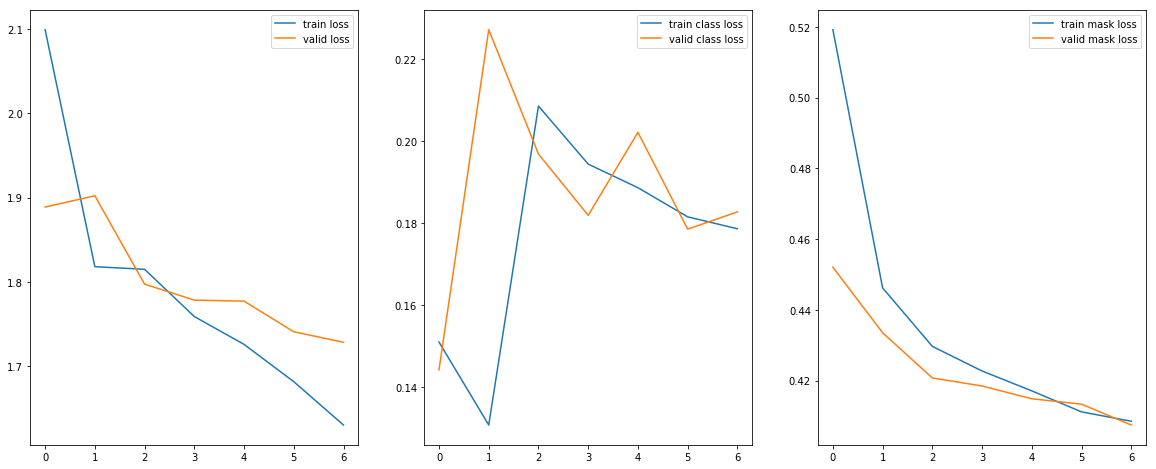

In [54]:
EP = range(0,7)
plt.figure(figsize=(20, 8))

plt.subplot(131)
plt.plot(EP, history['loss'], label="train loss")
plt.plot(EP, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(EP, history['mrcnn_class_loss'], label="train class loss")
plt.plot(EP, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(EP, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(EP, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()


In [75]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

Best epoch:  7
Valid loss:  1.728187307357788


# Load the best weights and visual assessment on small sample

In [81]:
class InferenceConfig(CloudConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

In [82]:
glob_list = glob.glob(f'../../working/cloud*/mask_rcnn_cloud_{best_epoch:04d}.h5')
model_path = glob_list[0] if glob_list else ''
model.load_weights(model_path, by_name=True)

Re-starting from epoch 7


original_image           shape: (512, 512, 3)         min:    0.00000  max:  253.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max:  512.00000  int64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int64
gt_bbox                  shape: (1, 4)                min:    3.00000  max:  467.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  uint8
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  142.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


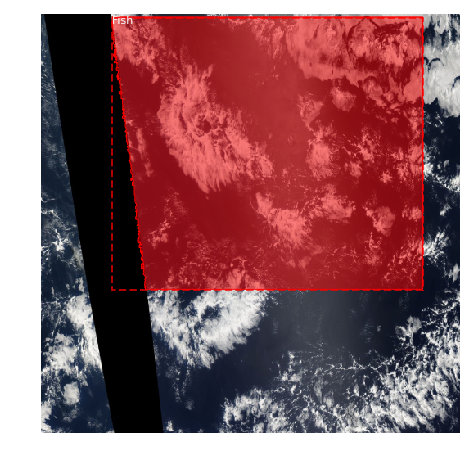

In [83]:
# Test on a random image
image_id = random.choice(valid_data.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(valid_data, inference_config, 
                           image_id, use_mini_mask=False)
info = valid_data.image_info[image_id]


log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            valid_data.class_names, figsize=(8, 8))

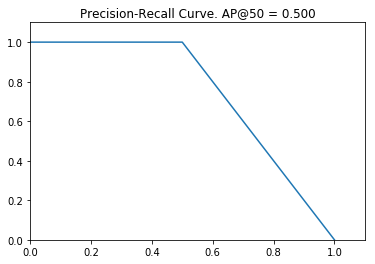

In [92]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

In [97]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(valid_data.image_ids, 50)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(valid_data, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs), "recall:" , np.mean(recalls))

mAP:  0.28000000178813933 recall: 0.5


In [98]:
# Fix overlapping masks
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [99]:
sample_df = pd.read_csv("../../input/understanding_cloud_organization/sample_submission.csv")
sample_df.head()

Image_Label EncodedPixels
0    002f507.jpg_Fish           1 1
1  002f507.jpg_Flower           1 1
2  002f507.jpg_Gravel           1 1
3   002f507.jpg_Sugar           1 1
4    0035ae9.jpg_Fish           1 1

In [100]:
test_df = pd.DataFrame(columns=["image_id","EncodedPixels","CategoryId"])
for idx,row in sample_df.iterrows():
    image_filename = row.Image_Label.split("_")[0]
    test_df = test_df.append({"image_id": image_filename},ignore_index=True)
test_df = test_df.drop_duplicates()

In [101]:
test_df.head()

image_id EncodedPixels CategoryId
0   002f507.jpg           NaN        NaN
4   0035ae9.jpg           NaN        NaN
8   0038327.jpg           NaN        NaN
12  004f759.jpg           NaN        NaN
16  005ba08.jpg           NaN        NaN

../../input/understanding_cloud_organization/test_images/ea35f97.jpg

*** No instances to display *** 



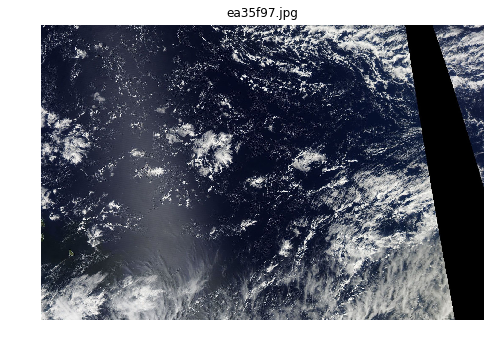

../../input/understanding_cloud_organization/test_images/8e4880d.jpg


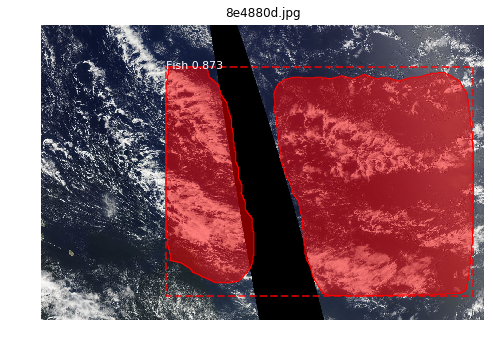

../../input/understanding_cloud_organization/test_images/76bfdd2.jpg


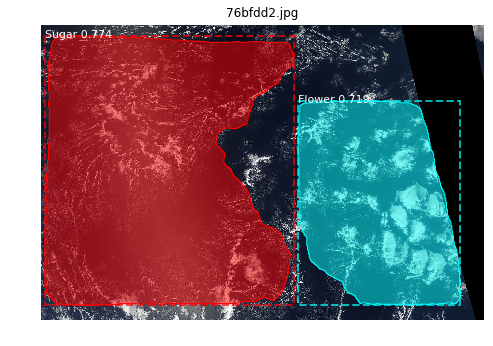

../../input/understanding_cloud_organization/test_images/c4a67e3.jpg


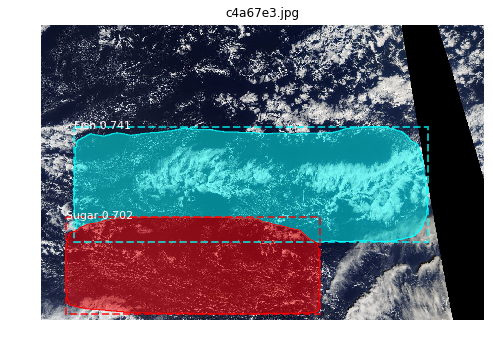

../../input/understanding_cloud_organization/test_images/5ef6aff.jpg


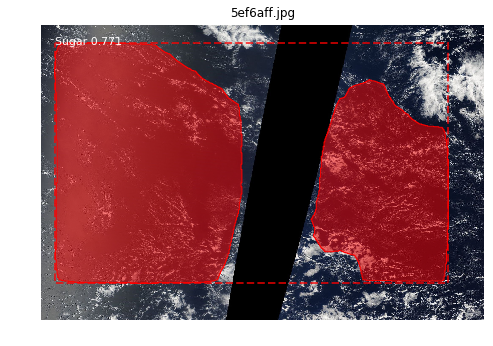

../../input/understanding_cloud_organization/test_images/75a06d3.jpg


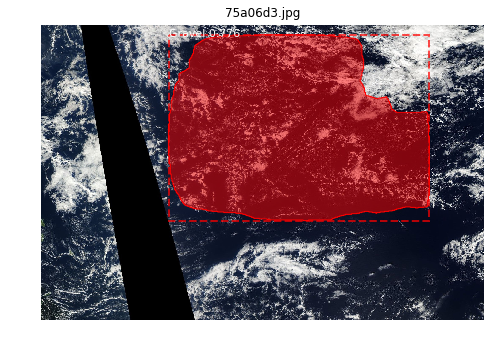

../../input/understanding_cloud_organization/test_images/2707de9.jpg


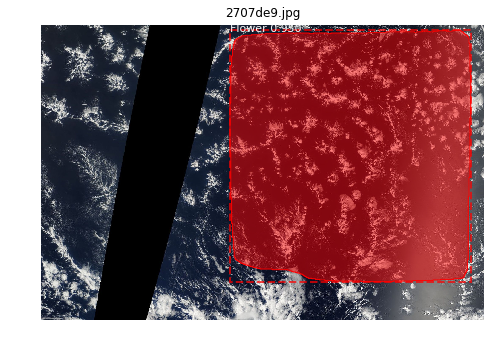

../../input/understanding_cloud_organization/test_images/985cad8.jpg

*** No instances to display *** 



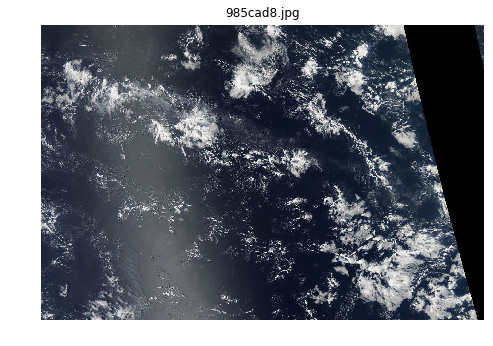

../../input/understanding_cloud_organization/test_images/1fea6cc.jpg

*** No instances to display *** 



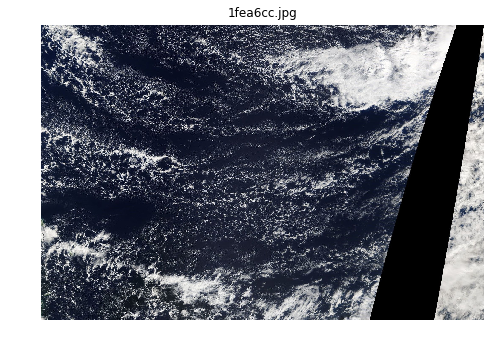

../../input/understanding_cloud_organization/test_images/3cb51e8.jpg


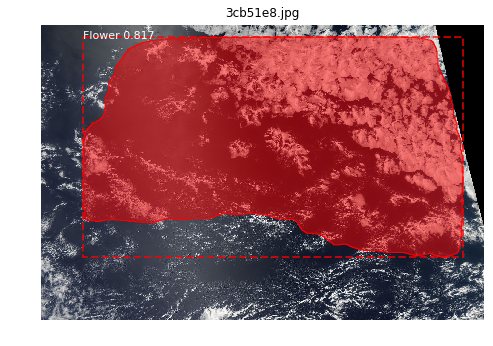

In [110]:
for i in range(10):
    image_id = test_df.sample()["image_id"].values[0]
    image_path = str('../../input/understanding_cloud_organization/test_images/'+image_id)
    print(image_path)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+category_list, r['scores'],
                                title=image_id, figsize=(8, 8))

# Submit predictions

In [111]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join([str(x) for x in run_lengths])

Due to the rectangular shape of the groundtruth, I have decided to use the ROIs and not the masks given by the MaskRCNN. The regions in images where there are no data are removed from the ROIs before generating the RLE. More experimentation will be required.

In [112]:
submission_df = sample_df.copy()
submission_df["EncodedPixels"] = ""
with tqdm(total=len(test_df)) as pbar:
    for i,row in test_df.iterrows():
        pbar.update(1)
        image_id = row["image_id"]
        image_path = str('../../input/understanding_cloud_organization/test_images/'+image_id)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        result = model.detect([resize_image(image_path)])
        r = result[0]

        if r['masks'].size > 0:
            masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
            for m in range(r['masks'].shape[-1]):
                masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                            (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

            y_scale = img.shape[0]/IMAGE_SIZE
            x_scale = img.shape[1]/IMAGE_SIZE
            rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
            masks, rois, class_ids = r['masks'], r['rois'], r['class_ids']

            #The following piece of code is creating rectangular masks from
            # the ROIs instead of using the masks drawn by the MaskRCNN.
            # It also removes any missing area from the imagery from the predicted masks.
            # Everything is added directly to the submission dataframe.
            rectangular_masks = []
            mask_dict = {"Fish":[],"Flower":[],"Gravel":[],"Sugar":[]}
            for roi, class_id in zip(rois, class_ids):
                rectangular_mask = np.zeros((512,512))
                rectangular_mask[roi[0]:roi[2], roi[1]:roi[3]] = 255
                img = cv2.resize(img, dsize=(512,512), interpolation = cv2.INTER_LINEAR)
                cropped_img = img[roi[0]:roi[2], roi[1]:roi[3]]
                
                kernel = np.ones((5,5),np.uint8)
                missing_data = np.where(cropped_img[:,:,0]==0,255,0).astype('uint8')
                contour_mask = np.zeros(missing_data.shape)
                opening = cv2.morphologyEx(missing_data.astype('uint8'), cv2.MORPH_OPEN, kernel)
                contours= cv2.findContours(opening,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
                if len(contours[0])>0:
                    largest_contour = max(contours[0], key = cv2.contourArea)
                    cv2.fillPoly(contour_mask, pts =[largest_contour], color=(255))
                    kernel = np.ones((5,5),np.uint8)
                    opening = cv2.morphologyEx(contour_mask, cv2.MORPH_OPEN, kernel)
                    fixed_mask = np.where(opening[:,:]==255,0,255)
                    rectangular_mask[roi[0]:roi[2], roi[1]:roi[3]] = fixed_mask.copy()
                    
                if mask_dict[category_list[class_id-1]]==[]:
                    mask_dict[category_list[class_id-1]] = rectangular_mask
                else:
                    previous_mask = mask_dict[category_list[class_id-1]].copy()
                    #prevents a bug where the mask is in int64
                    previous_mask = previous_mask.astype('float64')
                    boolean_mask = np.ma.mask_or(previous_mask, rectangular_mask)
                    merged_mask = np.where(boolean_mask, 255, 0)
                    mask_dict[category_list[class_id-1]] = merged_mask

            
            #Going through the masks per category and create a md mask in RLE
            for cloud_category in mask_dict.keys():
                if mask_dict[cloud_category]!=[]:
                    #resizing for submission
                    resized_mask = cv2.resize((mask_dict[cloud_category]/255).astype('uint8'), dsize=(525,350), interpolation = cv2.INTER_LINEAR)
                    rle_str = rle_encoding(resized_mask)
                    image_label = "{}_{}".format(image_id,cloud_category)
                    submission_df.loc[submission_df['Image_Label']==image_label,'EncodedPixels'] = rle_str
        else:
            masks, rois = r['masks'], r['rois']

100%|██████████| 3698/3698 [18:44<00:00,  3.33it/s]


In [113]:
submission_df.query("EncodedPixels!=''").head()

Image_Label                                      EncodedPixels
2   002f507.jpg_Gravel  6307 3 6320 3 6333 3 6346 3 6361 3 6374 3 6387...
9   0038327.jpg_Flower  136385 116 136735 116 137085 116 137435 116 13...
11   0038327.jpg_Sugar  2594 204 2944 204 3294 204 3644 204 3994 204 4...
13  004f759.jpg_Flower  46905 7 46913 1 46916 1 46918 7 46926 1 46929 ...
18  005ba08.jpg_Gravel  74555 7 74563 12 74576 4 74581 12 74594 9 7460...

In [115]:
submission_df.to_csv("../../working/submission.csv",index=False)

### Thanks for reading my kernel. Feel free to post some feedback!
### If you find this kernel helpful, please give an upvote! 